In [1]:
from sympy import *
import numpy as np
from itertools import combinations
import pandas as pd
import numpy as np

from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)


(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x1561192d0>)

Lambda is 
 [[0 0 0]
 [0 0 0]
 [0 1 0]]


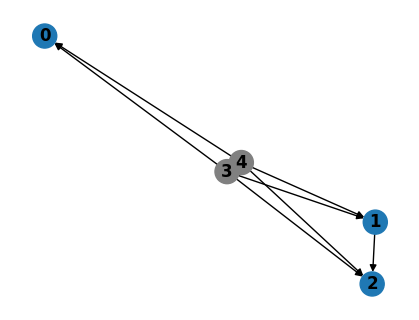

In [2]:
Lambda = get_Lambda([(2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1, 2], [1, 2], [1, 2]])
highest_l = 2
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [13]:
ReLVLiNGAM.__dict__

mappingproxy({'__module__': 'direct_lingam.ReLVLiNGAM',
              '__init__': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM.__init__(self, X, highest_l, verbose=False, only_lowest_order_equations=True, threshold_power=0.125, thresholds=[0.008, 0.8], scale_partly=True)>,
              'fit': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM.fit(self, X)>,
              '_estimate_cumulants': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM._estimate_cumulants(self, X)>,
              '_estimate_moments': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM._estimate_moments(self, X)>,
              '_process_last_node': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM._process_last_node(self, last_node, cumulants)>,
              '_form_symbol_to_cumulant_dict': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM._form_symbol_to_cumulant_dict(self, cumulants, nodes, scale_partly)>,
              '_find_source': <function direct_lingam.ReLVLiNGAM.ReLVLiNGAM._find_source(self, remaining_nodes, cumulants)>,


In [3]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
from itertools import permutations
class CMLiNGAM(ReLVLiNGAM):
    def __init__(self,
                 *args,
                 **kwargs):
        """
        Initialize the DiDLiNGAM model.

        Parameters:
        *args: positional arguments
        **kwargs: keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.cumulants = self._estimate_cumulants(self.X)
        self.roots_10 = np.array(sorted(self._get__roots(i=1, j=0), key = lambda x: np.abs(x)))
        self.roots_20 = np.array(sorted(self._get__roots(i=2, j=0), key = lambda x: np.abs(x)))
        self.roots_21 = np.array(sorted(self._get__roots(i=2, j=1), key = lambda x: np.abs(x)))



    def estimate_effect(self, method = "cumulant", true_B = None):
        """
        Estimate the causal effect using the specified method.

        Parameters:
        method (str): The method to use for effect estimation. Can be "ratio" or "cumulant".

        Raises:
        ValueError: If the specified method is not supported.
        """



        # match = self._match_marginals(self.roots_20, self.roots_21)
        cumulants_10 = self._marginal__cumulants(self.roots_10, j=0, i=1)
        cumulants_20 = self._marginal__cumulants(self.roots_20, j=0, i=2)
        match = self._match_marginals(cumulants_10[1:], cumulants_20[1:])

        roots_ratio = [0] + [self.roots_20[i + 1]/self.roots_10[match[i] + 1] for i in range(self.roots_10.shape[0] - 1)]
        match_roots = self._match_marginals(np.array(roots_ratio), self.roots_21)

        return self.roots_21[match_roots[0]]


    def _get__roots(self, i=1, j=0):
        """
        Get the roots of the polynomial equations for the specified nodes.

        Parameters:
        i (int): The index of the first node.
        j (int): The index of the second node.

        Returns:
        numpy.ndarray: The roots of the polynomial equations.
        """
        equations_bij = get_constraints_for_l_latents(self.highest_l)["equations_bij"]

        eq = equations_bij[0]
        specify_nodes = {
            sym: symbols(
                sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))
            )
            for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij])
            if str(sym) != "b_ij"
        }
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
        estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
        if j == 0:
            estimated_coeffs[-1] = 0
            # print(estimated_coeffs, np.polynomial.Polynomial(estimated_coeffs[::-1]))
        roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)

        return roots

    def _marginal__cumulants(self, roots, j=0, i=1):
        """
        Estimate the marginal cumulants for the specified nodes.

        Parameters:
        j (int): The index of the first node.
        i (int): The index of the second node.

        Returns:
        numpy.ndarray: The estimated marginal cumulants.
        """
        source, other_node = j, i
        l = self.highest_l  # The number of latent variables confounding 1 and 2
        # For k < l+1, the marginal omega cannot be inferred.
        k = l +1
        B_tilde = [roots ** i for i in range(k)]
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
        y = np.array(
            [
                float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),) * (k - i) + (str(other_node),) * i))}")])
                for i in range(k)
            ]
        )
        try:
            marginal_omegas = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
        except np.linalg.LinAlgError:
            raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")
        return marginal_omegas

    def _match_marginals(self, marginal_omegas_10, marginal_omegas_20):
        """
        Match the marginal cumulants of the two nodes.

        Parameters:
        marginal_omegas_10 (numpy.ndarray): The marginal cumulants of node 1.
        marginal_omegas_20 (numpy.ndarray): The marginal cumulants of node 2.

        Returns:
        list: The matching indices for the marginal cumulants.
        """
        if marginal_omegas_10.shape[0] != marginal_omegas_20.shape[0]:
            raise ValueError("The number of rows of the marginal omegas must be the same.")
        # if marginal_omegas_10.shape[1] != marginal_omegas_20.shape[1]:
        #     raise ValueError("The number of columns of the marginal omegas must be the same.")
        min_dist = np.inf
        for i in permutations(range(marginal_omegas_10.shape[0])):
            dist = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20[list(i)])))
            if dist < min_dist:
                min_dist = dist
                match = i
        return np.array(match)

In [4]:
X, true_B = simulate_data(1000, noise_distribution='gamma', Lambda=Lambda, Gamma=Gamma, permute_order=False)
causal_effect_true = true_B[2, 1]

In [5]:
# Perform the experiment
causal_effect_estimate = []

X_sample = np.asfortranarray(X)
X_sample = X_sample - np.mean(X_sample, axis=0)

model = CMLiNGAM(X_sample, highest_l=highest_l)
model.estimate_effect()

/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_21193/2069213220.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


-0.3150206983646026

In [16]:
Z, T, Y = X_sample[:,0], X_sample[:,1], X_sample[:,2]

In [21]:
np.vstack((T, Y, Z)).T.shape

(1000, 3)

In [6]:
model.roots_20, model.roots_21, model.roots_10

(array([ 0.        , -2.75176708, -2.75176708]),
 array([-0.3150207 , -0.77603481, -1.09916981]),
 array([0.        , 2.49767468, 2.49767468]))

In [7]:
true_B

array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.84642661,  0.        ],
       [ 0.        , -0.8201708 ,  1.        , -1.34090874,  0.        ]])

In [8]:
# Perform the experiment
causal_effect_estimate = []

X_sample = np.asfortranarray(X)
X_sample = X_sample - np.mean(X_sample, axis=0)

model = CMLiNGAM(X_sample, highest_l=highest_l)
model.estimate_effect()


/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_21193/2069213220.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


-0.3150206983646026

In [9]:
model.roots_10, model.roots_20, model.roots_21

(array([0.        , 2.49767468, 2.49767468]),
 array([ 0.        , -2.75176708, -2.75176708]),
 array([-0.3150207 , -0.77603481, -1.09916981]))

In [10]:
true_B

array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.84642661,  0.        ],
       [ 0.        , -0.8201708 ,  1.        , -1.34090874,  0.        ]])

In [11]:
import concurrent.futures

reps = 20
seeds_df = []
parameter_sets = list(range(reps))

def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    noise_distribution = 'gamma'
    samples_sizes = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]

    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        model = CMLiNGAM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
    })
    return seed_df



# create a thread pool executor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # submit each experiment to the executor
    print(f"Using {executor._max_workers} processes")
    futures = [executor.submit(run_experiment, params) for params in parameter_sets]

    # wait for all experiments to complete and store the results
    for future in concurrent.futures.as_completed(futures):
        seeds_df.append(future.result())

# process the results as needed
results_df = pd.concat(seeds_df, ignore_index=True)

Using 12 processes


/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_21193/2069213220.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


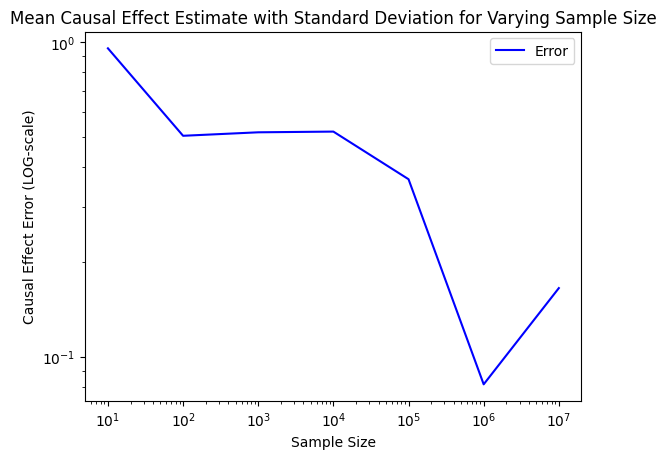

In [12]:
import matplotlib.pyplot as plt

results_df["Error"] = np.abs((results_df['Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error


# Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').median()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Error"],
         label='Error',
         color = "blue")



plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()